In [ ]:
pip uninstall -y tensorflow tensorflow-cpu tensorflow-intel tensorflow-macos keras keras-nlp keras-cv


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: keras-nlp 0.21.1
Uninstalling keras-nlp-0.21.1:
  Successfully uninstalled keras-nlp-0.21.1


Compare when in Clean data situation, Gpt2-small and Gpt2-medium

In [ ]:
import os
import random
import json
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    pipeline
)
from peft import get_peft_model, LoraConfig, TaskType

# Device selection: use 'cuda:0' if a GPU is available; otherwise CPU.

DEVICE = 0 if torch.cuda.is_available() else -1

# 1) Generate 1,000 synthetic samples containing only the fields "tax" and "year".
# The random seed ensures reproducibility;
def generate_samples(n=1000, seed=42):
    random.seed(seed)
    templates = [
        "Set a carbon tax of ${tax} per ton in {year}.",
        "In {year}, impose a tax of ${tax}/t.",
        "Apply ${tax} carbon levy by {year}.",
        "By year {year}, tax CO2 at ${tax} per tonne.",
        "What about charging ${tax} tax in {year}?"
    ]
    samples = []
    for _ in range(n):
        tax = random.choice(range(0, 201, 1))
        year = random.choice(range(2020, 2100))
        query = random.choice(templates).format(tax=tax, year=year)
        samples.append({"query": query, "tax": tax, "year": year})
    return pd.DataFrame(samples)

# Train/validation split 80/20
df = generate_samples(1000)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Utility: extract the first JSON object from a generated string.
# Returns {} on parse failure. Make sure robust
def extract_json(output: str):
    # Extract the first JSON object string and parse it.
    if "{" in output and "}" in output:
        js_str = output[output.find("{"):output.rfind("}")+1]
        try:
            return json.loads(js_str)
        except json.JSONDecodeError:
            return {}
    return {}

# Evaluate exact-match (EM) accuracy for the 'tax' and 'year'
# EM show correct when the parsed numeric value = the truth
def eval_model(pipe, df_val):
    metrics = {"tax": 0, "year": 0}
    total = len(df_val)
    for key in metrics:
        correct = 0
        for row in df_val.itertuples():
            prompt = (
                f'User query: "{row.query}"\n'
                "Extract tax, year from the query as a JSON object.\n"
                "Output only the JSON object (no extra text):"
            )
            out = pipe(prompt)[0]["generated_text"]
            js = extract_json(out)
            if js.get(key) == getattr(row, key):
                correct += 1
        metrics[key] = correct / total
    return metrics

# Baseline means no fine-tuning : load a pretrained causal LM and evaluate EM.

# Set the pad token to EOS in order to avoid pad-index warnings in GPT-2 family models
def eval_baseline(model_name):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    tok.pad_token = tok.eos_token
    tok.pad_token_id = tok.eos_token_id
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.config.pad_token_id = tok.eos_token_id

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tok,
        device=DEVICE,
        do_sample=False,
        max_new_tokens=30
    )
    return eval_model(pipe, df_val)

# LoRA fine-tuning : only train the low-rank adapter weights.  Froze base weights
# Training labels are useed to completion tokens
# Prompt tokens -100 in orrder to exclude them from the loss.
def train_and_eval_lora(model_name):
    # set prompt completion pairs for supervised fine-tuning
    rows = []
    for row in df_train.itertuples():
        prompt = (
            f'User query: "{row.query}"\n'
            "Extract tax, year from the query as a JSON object.\n"
            "Output only the JSON object (no extra text):"
        )
        completion = json.dumps({"tax": row.tax, "year": row.year})
        rows.append({"prompt": prompt, "completion": " " + completion})
    ds = Dataset.from_pandas(pd.DataFrame(rows))

    # Tokenizer and base model.
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    tok.pad_token = tok.eos_token
    tok.pad_token_id = tok.eos_token_id
    base = AutoModelForCausalLM.from_pretrained(model_name)
    base.config.pad_token_id = tok.eos_token_id

    # Attach LoRA adapters for causal LM.
    model = get_peft_model(
        base,
        LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=8,
            lora_alpha=32,
            lora_dropout=0.05
        )
    )

    # Preprocess
    def preprocess(ex):
        txt = ex["prompt"] + ex["completion"]
        enc = tok(txt, truncation=True, padding="max_length", max_length=128)
        pr_len = len(tok(ex["prompt"], truncation=True, max_length=128).input_ids)
        labels = [-100] * pr_len + enc.input_ids[pr_len:]
        labels += [-100] * (128 - len(labels))
        return {
            "input_ids": enc.input_ids,
            "attention_mask": enc.attention_mask,
            "labels": labels
        }

    train_ds = ds.map(preprocess, remove_columns=ds.column_names)

    # Trainer configuration
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=f"{model_name}_tax_year_lora",
            num_train_epochs=5,
            per_device_train_batch_size=4,
            learning_rate=1e-4,
            logging_steps=50,
            save_total_limit=1,
            report_to=[]
        ),
        train_dataset=train_ds,
        tokenizer=tok
    )
    trainer.train()

    # Inference: greedy decoding, short max_new_tokens and evaluate with the same EM metric.
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tok,
        device=DEVICE,
        do_sample=False,
        max_new_tokens=30
    )
    return eval_model(pipe, df_val)

if __name__ == "__main__":
    # 1) Baselines for GPT-2 and GPT-2 Medium (no fine-tuning).
    baselines = {
        "gpt2": eval_baseline("gpt2"),
        "gpt2-medium": eval_baseline("gpt2-medium")
    }
    print("Baseline accuracies:", baselines)

    # 2) LoRA fine-tuning and evaluation for GPT-2 (small).
    ft_small = train_and_eval_lora("gpt2")
    print("GPT-2 small LoRA fine-tuned acc:", ft_small)

    # 3) LoRA fine-tuning and evaluation for GPT-2 Medium.
    ft_medium = train_and_eval_lora("gpt2-medium")
    print("GPT-2 medium LoRA fine-tuned acc:", ft_medium)


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Baseline accuracies: {'gpt2': {'tax': 0.0, 'year': 0.01}, 'gpt2-medium': {'tax': 0.01, 'year': 0.02}}


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-2175729129.py:146: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,3.890100
100,0.185600
150,0.026600
200,0.013900
250,0.008400
300,0.005000
350,0.004000
400,0.004900
450,0.002100
500,0.002200


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


GPT-2 small LoRA fine-tuned acc: {'tax': 0.98, 'year': 0.985}


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-2175729129.py:146: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


GPT-2 medium LoRA fine-tuned acc: {'tax': 1.0, 'year': 1.0}


Find the optimal parameter combination for the GPT2-medium model

Running sweep sample_size = 500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,5.591900
100,0.136100
150,0.007300
200,0.003600
250,0.001900
300,0.003400
350,0.001000
400,0.002000
450,0.000700
500,0.000700


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Running sweep sample_size = 1000


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep sample_size = 2000


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.562300
100,0.122000
150,0.006900
200,0.002900
250,0.002000
300,0.002200
350,0.001700
400,0.000500
450,0.000500
500,0.000700


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


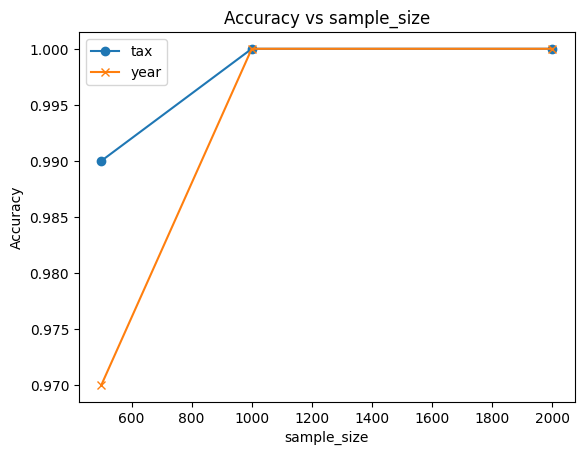

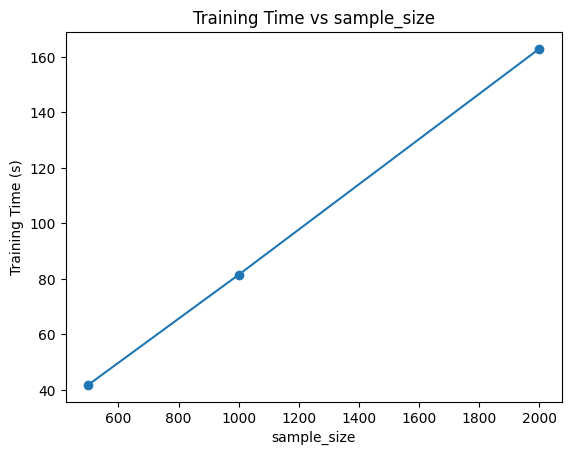

Running sweep r = 4


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.676200
100,0.128700
150,0.005800
200,0.003000
250,0.000700
300,0.001000
350,0.001200
400,0.000600
450,0.001000
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep r = 8


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep r = 16


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.654500
100,0.138200
150,0.009600
200,0.005600
250,0.001400
300,0.001800
350,0.001200
400,0.001900
450,0.001000
500,0.000800


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


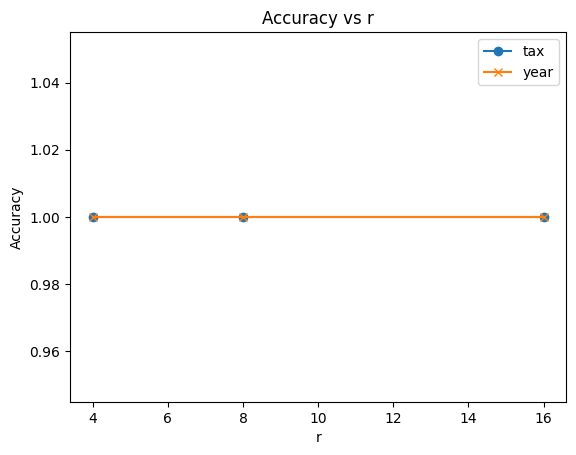

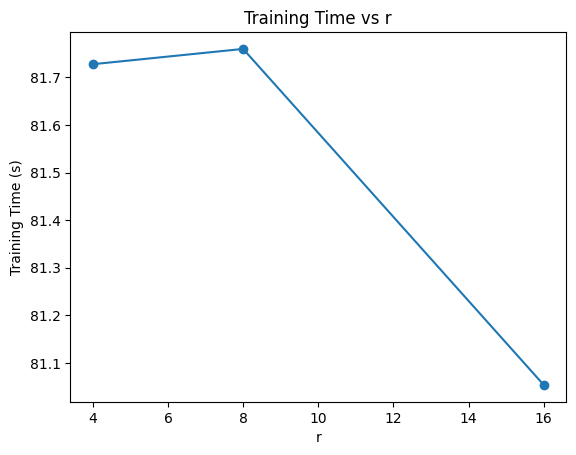

Running sweep lora_alpha = 16


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,7.447300
100,0.977500
150,0.033500
200,0.012500
250,0.003700
300,0.003500
350,0.002800
400,0.003300
450,0.001900
500,0.001600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep lora_alpha = 32


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep lora_alpha = 64


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,3.764500
100,0.022900
150,0.003200
200,0.001300
250,0.000400
300,0.001000
350,0.001100
400,0.000400
450,0.000300
500,0.000200


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


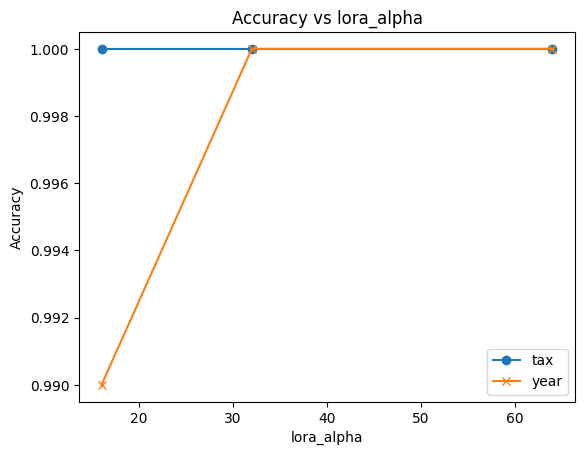

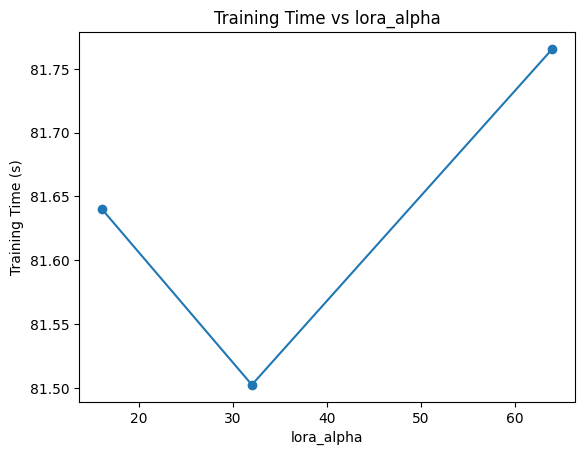

Running sweep lora_dropout = 0.0


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.580100
100,0.122200
150,0.007900
200,0.003200
250,0.002600
300,0.002400
350,0.001100
400,0.002400
450,0.000500
500,0.001900


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep lora_dropout = 0.1


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.588200
100,0.129300
150,0.007600
200,0.004400
250,0.001000
300,0.001500
350,0.001200
400,0.001000
450,0.000800
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep lora_dropout = 0.2


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.643000
100,0.138500
150,0.007700
200,0.004700
250,0.001000
300,0.001600
350,0.001100
400,0.001300
450,0.001100
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


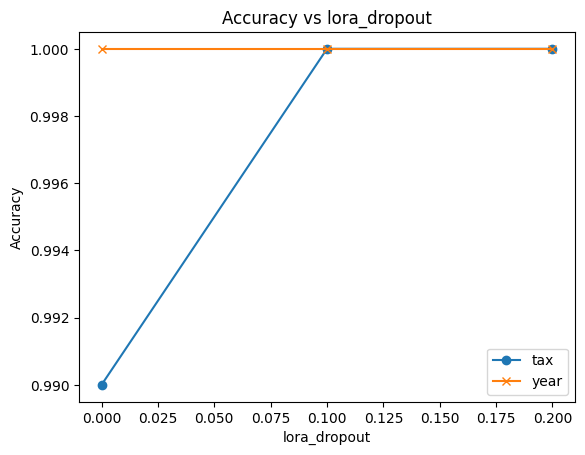

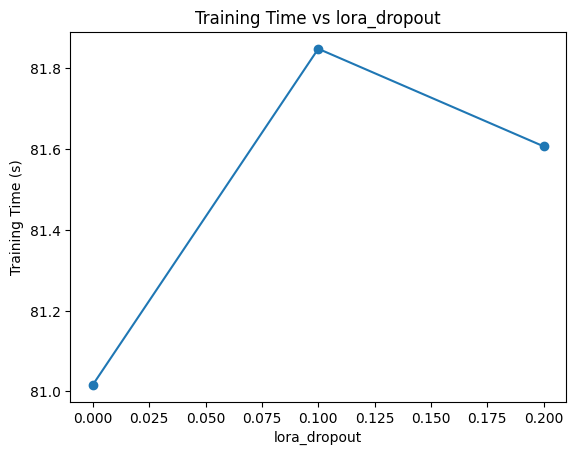

Running sweep num_train_epochs = 3


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.626200
100,0.140500
150,0.008200
200,0.005100
250,0.001100
300,0.001700
350,0.001500
400,0.001900
450,0.001200
500,0.000900


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep num_train_epochs = 5


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.547100
100,0.134700
150,0.007800
200,0.005200
250,0.001200
300,0.001400
350,0.001600
400,0.002000
450,0.001000
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep num_train_epochs = 10


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.540300
100,0.122000
150,0.006900
200,0.004000
250,0.000900
300,0.001300
350,0.001300
400,0.000700
450,0.000700
500,0.000400


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


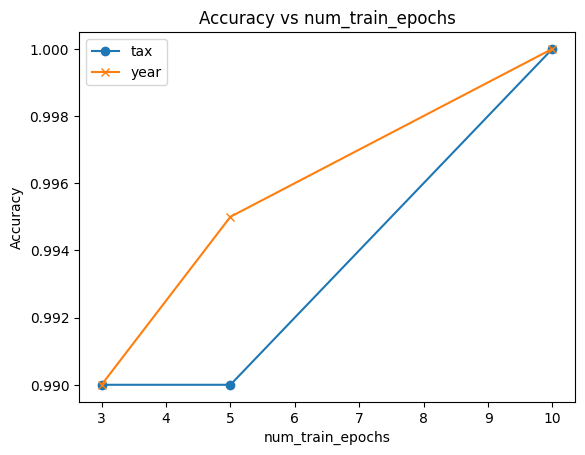

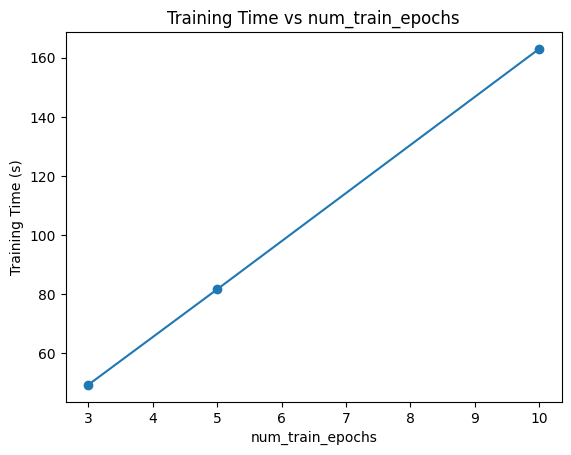

Running sweep per_device_train_batch_size = 2


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.593700
100,0.129200
150,0.009300
200,0.005700
250,0.003800
300,0.001500
350,0.001800
400,0.001200
450,0.001400
500,0.001500


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep per_device_train_batch_size = 4


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep per_device_train_batch_size = 8


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.569100
100,0.138700
150,0.006600
200,0.003000
250,0.002200
300,0.002800
350,0.002300
400,0.000900
450,0.001600
500,0.001100


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


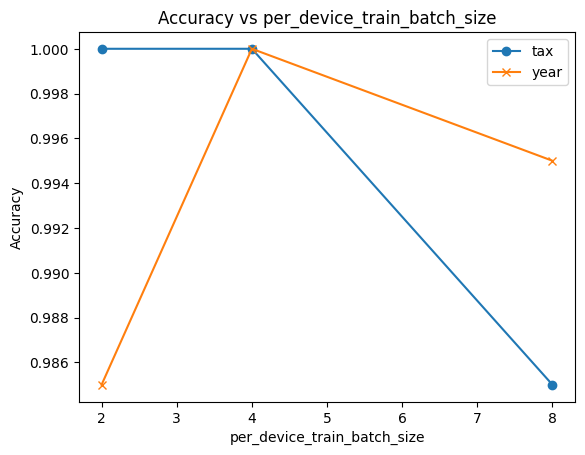

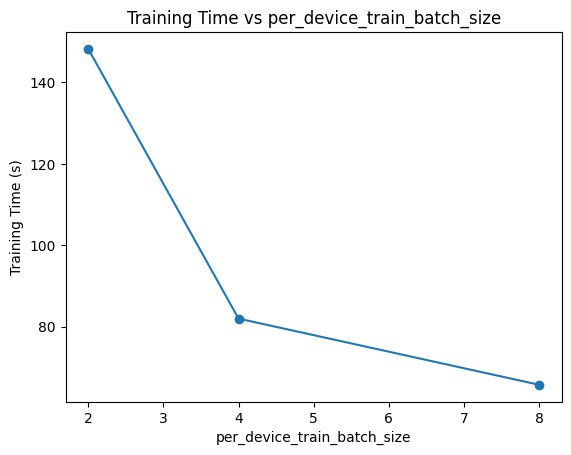

Running sweep learning_rate = 5e-05


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,8.034200
100,2.465000
150,0.097300
200,0.019600
250,0.006400
300,0.005000
350,0.004200
400,0.004900
450,0.002500
500,0.002300


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep learning_rate = 0.0001


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep learning_rate = 0.0005


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.489400
100,0.002000
150,0.001000
200,0.000200
250,0.000400
300,0.001100
350,0.000100
400,0.000100
450,0.000000
500,0.000000


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


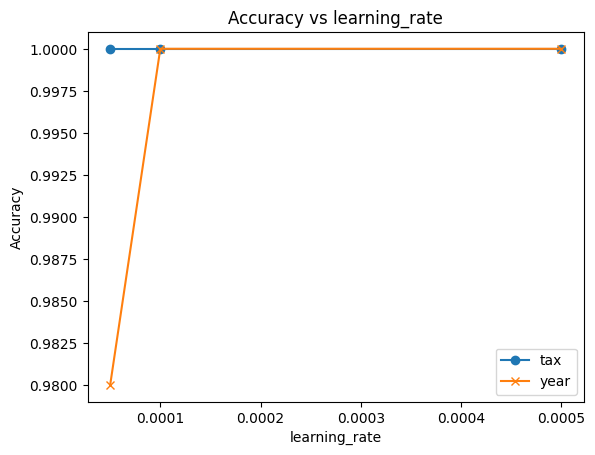

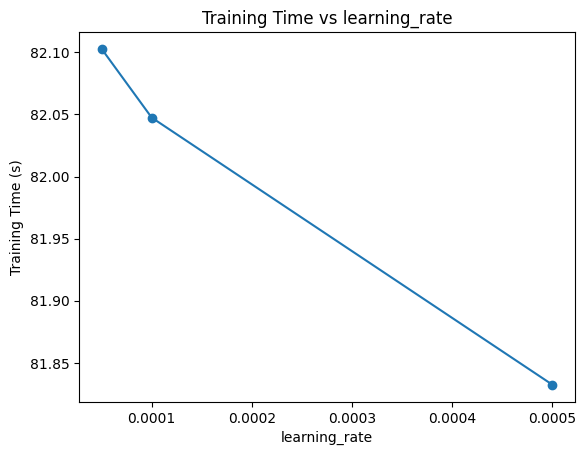

Running sweep logging_steps = 10


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,9.180500
20,7.942600
30,6.006000
40,3.533300
50,1.218900
60,0.385300
70,0.150000
80,0.068300
90,0.029600
100,0.014100


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep logging_steps = 50


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep logging_steps = 100


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,2.852900
200,0.006000
300,0.001200
400,0.001200
500,0.000700
600,0.000500
700,0.000800
800,0.000500
900,0.000700
1000,0.000300


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


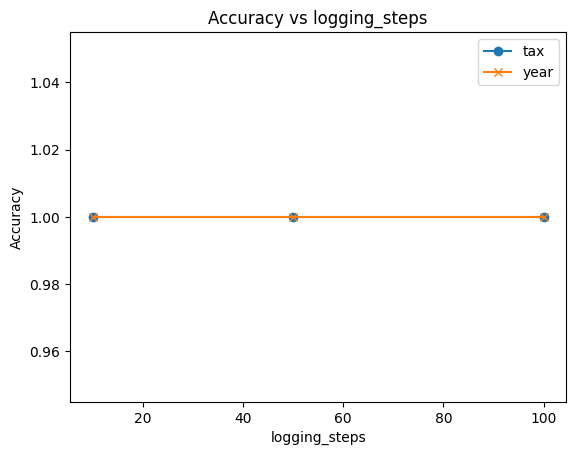

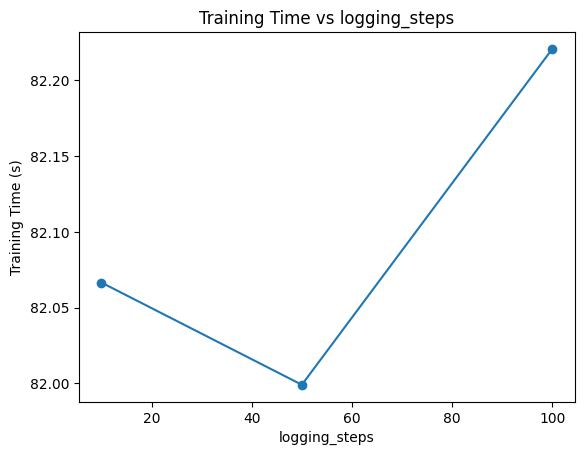

Running sweep save_total_limit = 1


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep save_total_limit = 2


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running sweep save_total_limit = 5


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-4120491253.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,5.576300
100,0.129500
150,0.007500
200,0.004400
250,0.001000
300,0.001500
350,0.001400
400,0.001100
450,0.000900
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


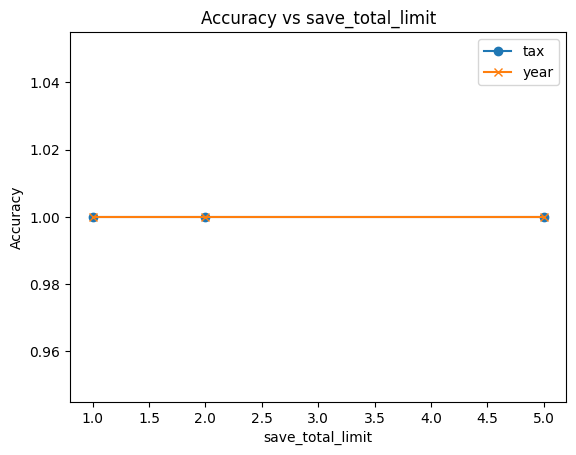

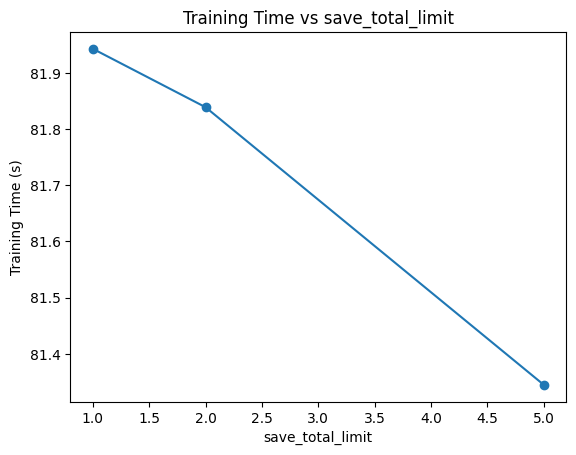

In [ ]:
import time
import random
import json
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, pipeline
from peft import get_peft_model, LoraConfig, TaskType
import matplotlib.pyplot as plt


DEVICE = 0 if torch.cuda.is_available() else -1


def generate_samples(n=1000, seed=42):
    random.seed(seed)
    templates = [
        "Set a carbon tax of ${tax} per ton in {year}.",
        "In {year}, impose a tax of ${tax}/t.",
        "Apply ${tax} carbon levy by {year}.",
        "By year {year}, tax CO2 at ${tax} per tonne.",
        "What about charging ${tax} tax in {year}?"
    ]
    samples = []
    for _ in range(n):
        tax = random.choice(range(0, 201, 1))
        year = random.choice(range(2020, 2100))
        query = random.choice(templates).format(tax=tax, year=year)
        samples.append({"query": query, "tax": tax, "year": year})
    return pd.DataFrame(samples)


def extract_json(output: str):
    if "{" in output and "}" in output:
        js_str = output[output.find("{"):output.rfind("}")+1]
        try:
            return json.loads(js_str)
        except json.JSONDecodeError:
            return {}
    return {}


def eval_model(pipe, df_val):
    metrics = {"tax": 0, "year": 0}
    total = len(df_val)
    for key in metrics:
        correct = 0
        for row in df_val.itertuples():
            prompt = (
                f'User query: "{row.query}"\n'
                "Extract tax, year from the query as a JSON object.\n"
                "Output only the JSON object (no extra text):"
            )
            out = pipe(prompt)[0]["generated_text"]
            js = extract_json(out)
            if js.get(key) == getattr(row, key):
                correct += 1
        metrics[key] = correct / total
    return metrics


def train_and_eval_lora(
    sample_size=1000,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=1e-4,
    logging_steps=50,
    save_total_limit=1
):
    df = generate_samples(sample_size)
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
    rows = []
    for row in df_train.itertuples():
        prompt = (
            f'User query: "{row.query}"\n'
            "Extract tax, year from the query as a JSON object.\n"
            "Output only the JSON object (no extra text):"
        )
        completion = json.dumps({"tax": row.tax, "year": row.year})
        rows.append({"prompt": prompt, "completion": " " + completion})
    ds = Dataset.from_pandas(pd.DataFrame(rows))

    tok = AutoTokenizer.from_pretrained("gpt2-medium", use_fast=True)
    tok.pad_token = tok.eos_token
    tok.pad_token_id = tok.eos_token_id
    base = AutoModelForCausalLM.from_pretrained("gpt2-medium")
    base.config.pad_token_id = tok.eos_token_id

    model = get_peft_model(
        base,
        LoraConfig(task_type=TaskType.CAUSAL_LM, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
    )

    def preprocess(ex):
        txt = ex["prompt"] + ex["completion"]
        enc = tok(txt, truncation=True, padding="max_length", max_length=128)
        pr = len(tok(ex["prompt"], truncation=True, max_length=128).input_ids)
        labels = [-100] * pr + enc.input_ids[pr:]
        labels += [-100] * (128 - len(labels))
        return {"input_ids": enc.input_ids, "attention_mask": enc.attention_mask, "labels": labels}

    train_ds = ds.map(preprocess, remove_columns=ds.column_names)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="temp_lora",
            num_train_epochs=num_train_epochs,
            per_device_train_batch_size=per_device_train_batch_size,
            learning_rate=learning_rate,
            logging_steps=logging_steps,
            save_total_limit=save_total_limit,
            report_to=[]
        ),
        train_dataset=train_ds,
        tokenizer=tok
    )

    start = time.time()
    trainer.train()
    elapsed = time.time() - start

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tok,
        device=DEVICE,
        do_sample=False,
        max_new_tokens=30
    )
    metrics = eval_model(pipe, df_val)
    metrics["time"] = elapsed
    return metrics

# Experimenting with Different Hyperparameters' Effects
sweeps = {
    "sample_size": [500, 1000, 2000],
    "r": [4, 8, 16],
    "lora_alpha": [16, 32, 64],
    "lora_dropout": [0.0, 0.1, 0.2],
    "num_train_epochs": [3, 5, 10],
    "per_device_train_batch_size": [2, 4, 8],
    "learning_rate": [5e-5, 1e-4, 5e-4],
    "logging_steps": [10, 50, 100],
    "save_total_limit": [1, 2, 5]
}



# For each hyperparameter, draw two graphs: accuracy rate and training time.
for param, values in sweeps.items():
    tax_accs, year_accs, times = [], [], []
    for v in values:
        print(f"Running sweep {param} = {v}")
        m = train_and_eval_lora(**{param: v})
        tax_accs.append(m["tax"])
        year_accs.append(m["year"])
        times.append(m["time"])

    #Accuracy
    plt.figure()
    plt.plot(values, tax_accs, marker='o', label='tax')
    plt.plot(values, year_accs, marker='x', label='year')
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {param}')
    plt.legend()
    plt.show()

    # Training time chart
    plt.figure()
    plt.plot(values, times, marker='o')
    plt.xlabel(param)
    plt.ylabel('Training Time (s)')
    plt.title(f'Training Time vs {param}')
    plt.show()


The performance of GPT2-Medium under the optimal combination parameters

Running best-params (gpt2-medium + LoRA) ...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:2156: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-3281599749.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,5.546300
100,0.123000
150,0.006400
200,0.004100
250,0.000900
300,0.001300
350,0.001000
400,0.000700
450,0.000700
500,0.000600


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Best-params results:
{'tax': 1.0, 'year': 1.0}
Training time (s): 79.81


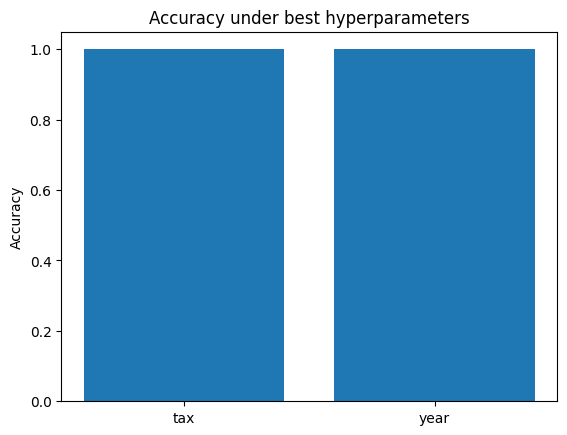

In [ ]:
import time
import random
import json
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, pipeline
from peft import get_peft_model, LoraConfig, TaskType
import matplotlib.pyplot as plt


DEVICE = 0 if torch.cuda.is_available() else -1


def generate_samples(n=1000, seed=42):
    random.seed(seed)
    templates = [
        "Set a carbon tax of ${tax} per ton in {year}.",
        "In {year}, impose a tax of ${tax}/t.",
        "Apply ${tax} carbon levy by {year}.",
        "By year {year}, tax CO2 at ${tax} per tonne.",
        "What about charging ${tax} tax in {year}?"
    ]
    samples = []
    for _ in range(n):
        tax = random.choice(range(0, 201, 1))
        year = random.choice(range(2020, 2100))
        query = random.choice(templates).format(tax=tax, year=year)
        samples.append({"query": query, "tax": tax, "year": year})
    return pd.DataFrame(samples)


def extract_json(output: str):
    if "{" in output and "}" in output:
        js_str = output[output.find("{"):output.rfind("}")+1]
        try:
            return json.loads(js_str)
        except json.JSONDecodeError:
            return {}
    return {}


def eval_model(pipe, df_val):
    metrics = {"tax": 0, "year": 0}
    total = len(df_val)
    for key in metrics:
        correct = 0
        for row in df_val.itertuples():
            prompt = (
                f'User query: "{row.query}"\n'
                "Extract tax, year from the query as a JSON object.\n"
                "Output only the JSON object (no extra text):"
            )
            out = pipe(prompt)[0]["generated_text"]
            js = extract_json(out)
            if js.get(key) == getattr(row, key):
                correct += 1
        metrics[key] = correct / total
    return metrics


def train_and_eval_lora(
    sample_size=1000,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=1e-4,
    logging_steps=50,
    save_total_limit=1
):
    df = generate_samples(sample_size)
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
    rows = []
    for row in df_train.itertuples():
        prompt = (
            f'User query: "{row.query}"\n'
            "Extract tax, year from the query as a JSON object.\n"
            "Output only the JSON object (no extra text):"
        )
        completion = json.dumps({"tax": row.tax, "year": row.year})
        rows.append({"prompt": prompt, "completion": " " + completion})
    ds = Dataset.from_pandas(pd.DataFrame(rows))

    tok = AutoTokenizer.from_pretrained("gpt2-medium", use_fast=True)
    tok.pad_token = tok.eos_token
    tok.pad_token_id = tok.eos_token_id
    base = AutoModelForCausalLM.from_pretrained("gpt2-medium")
    base.config.pad_token_id = tok.eos_token_id

    model = get_peft_model(
        base,
        LoraConfig(task_type=TaskType.CAUSAL_LM, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
    )

    def preprocess(ex):
        txt = ex["prompt"] + ex["completion"]
        enc = tok(txt, truncation=True, padding="max_length", max_length=128)
        pr = len(tok(ex["prompt"], truncation=True, max_length=128).input_ids)
        labels = [-100] * pr + enc.input_ids[pr:]
        labels += [-100] * (128 - len(labels))
        return {"input_ids": enc.input_ids, "attention_mask": enc.attention_mask, "labels": labels}

    train_ds = ds.map(preprocess, remove_columns=ds.column_names)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="temp_lora",
            num_train_epochs=num_train_epochs,
            per_device_train_batch_size=per_device_train_batch_size,
            learning_rate=learning_rate,
            logging_steps=logging_steps,
            save_total_limit=save_total_limit,
            report_to=[]
        ),
        train_dataset=train_ds,
        tokenizer=tok
    )

    start = time.time()
    trainer.train()
    elapsed = time.time() - start

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tok,
        device=DEVICE,
        do_sample=False,
        max_new_tokens=30
    )
    metrics = eval_model(pipe, df_val)
    metrics["time"] = elapsed
    return metrics

# ===== Run only the best configuration =====
BEST = {
    "sample_size": 1000,
    "r": 4,
    "lora_alpha": 32,
    "lora_dropout": 0.1,
    "num_train_epochs": 5,
    "per_device_train_batch_size": 4,
    "learning_rate": 1e-4,
    "logging_steps": 50,
    "save_total_limit": 5,
}

print("Running best-params (gpt2-medium + LoRA) ...")
best_metrics = train_and_eval_lora(**BEST)

print("Best-params results:")
print({"tax": best_metrics["tax"], "year": best_metrics["year"]})
print(f"Training time (s): {best_metrics['time']:.2f}")

# (Optional) quick plot of the two accuracies
plt.figure()
plt.bar(["tax", "year"], [best_metrics["tax"], best_metrics["year"]])
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.title("Accuracy under best hyperparameters")
plt.show()
